**Importing libraries and loading the data**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn  as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import math
import xgboost as xgb
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading all needed datasets from kaggle
calendar = pd.read_csv('../data/raw/calendar.csv')
sell_prices = pd.read_csv('../data/raw/sell_prices.csv')
sales_validation = pd.read_csv('../data/raw/sales_train_validation.csv')

**Exploratory Data Analysis**

In [ ]:
sales_validation.info

<bound method DataFrame.info of                                   id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d

In [ ]:
unique_items = len(sales_validation['item_id'].unique())
unique_item_categories = len(sales_validation['cat_id'].unique())
unique_departments = len(sales_validation['dept_id'].unique())
unique_stores = len(sales_validation['store_id'].unique())
unique_states = len(sales_validation['state_id'].unique())

print(f'Number of \n unique states: {unique_states} \n unique stores: {unique_stores} \n unique departments: {unique_departments} \n unique item categories: {unique_item_categories} \n unique items: {unique_items}')

Number of 
 unique states: 3 
 unique stores: 10 
 unique departments: 7 
 unique item categories: 3 
 unique items: 3049


In [ ]:
for col in [sales_validation['cat_id'],sales_validation['dept_id'],sales_validation['store_id'],sales_validation['state_id']]:
  print (col.unique())

['HOBBIES' 'HOUSEHOLD' 'FOODS']
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['CA' 'TX' 'WI']


In [ ]:
# Inspection of data types
print("Data types in sales_validation are: \n", sales_validation.dtypes.value_counts())

Data types in sales_validation are: 
 int64     1913
object       6
dtype: int64


In [ ]:
sales_validation.dtypes.head(6)

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

In [ ]:
duplicated_rows_count = sales_validation.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [ ]:
# Checking for null values column-wise
sales_validation.isna().sum(axis=1).sort_values(ascending=False)

0        0
20322    0
20334    0
20333    0
20332    0
        ..
10159    0
10158    0
10157    0
10156    0
30489    0
Length: 30490, dtype: int64

In [ ]:
# Checking for null values row-wise
sales_validation.isna().sum().sort_values(ascending=False)

id        0
d_1270    0
d_1282    0
d_1281    0
d_1280    0
         ..
d_630     0
d_629     0
d_628     0
d_627     0
d_1913    0
Length: 1919, dtype: int64

In [ ]:
calendar.info

<bound method DataFrame.info of             date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0    

In [ ]:
unique_year = len(calendar['year'].unique())
unique_events = len(calendar['event_name_1'].unique()) + len(calendar['event_name_2'].unique())
unique_states = len(calendar['event_type_1'].unique())
print(f'Number of \n unique years: {unique_year} \n unique events: {unique_events} \n unique types of events: {unique_states}')

Number of 
 unique years: 6 
 unique events: 36 
 unique types of events: 5


In [ ]:
for col in [calendar['year'],calendar['event_name_1'],calendar['event_type_1'],calendar['event_name_2']]:
  print (col.unique())

[2011 2012 2013 2014 2015 2016]
[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [ ]:
# Inspection of data types
print("Data types in calendar are: \n", calendar.dtypes.value_counts())

Data types in calendar are: 
 object    7
int64     7
dtype: int64


In [ ]:
calendar.dtypes.head(14)

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [ ]:
duplicated_rows_count = calendar.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [ ]:
#Checking for null values column-wise
calendar.isna().sum(axis=1).sort_values(ascending=False)

0       4
1281    4
1293    4
1292    4
1291    4
       ..
85      0
1233    0
827     0
1177    0
1968    0
Length: 1969, dtype: int64

In [ ]:
# Checking for null values row-wise
calendar.isna().sum().sort_values(ascending=False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [ ]:
sell_prices.info

<bound method DataFrame.info of         store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]>

In [ ]:
unique_store_sell = len(sell_prices['store_id'].unique())
unique_item_sell = len(sell_prices['item_id'].unique())
unique_id_week = len(sell_prices['wm_yr_wk'].unique())
unique_sell_price = len(sell_prices['sell_price'].unique())
print(f'Number of \n unique stores: {unique_store_sell} \n unique item ids: {unique_item_sell} \n unique id_weeks: {unique_id_week} \n unique sell_prices {unique_sell_price}')

Number of 
 unique stores: 10 
 unique item ids: 3049 
 unique id_weeks: 282 
 unique sell_prices 1048


In [ ]:
for col in [sell_prices['store_id'],sell_prices['item_id'],sell_prices['wm_yr_wk'],sell_prices['sell_price']]:
  print (col.unique())

['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
[11325 11326 11327 11328 11329 11330 11331 11332 11333 11334 11335 11336
 11337 11338 11339 11340 11341 11342 11343 11344 11345 11346 11347 11348
 11349 11350 11351 11352 11353 11401 11402 11403 11404 11405 11406 11407
 11408 11409 11410 11411 11412 11413 11414 11415 11416 11417 11418 11419
 11420 11421 11422 11423 11424 11425 11426 11427 11428 11429 11430 11431
 11432 11433 11434 11435 11436 11437 11438 11439 11440 11441 11442 11443
 11444 11445 11446 11447 11448 11449 11450 11451 11452 11501 11502 11503
 11504 11505 11506 11507 11508 11509 11510 11511 11512 11513 11514 11515
 11516 11517 11518 11519 11520 11521 11522 11523 11524 11525 11526 11527
 11528 11529 11530 11531 11532 11533 11534 11535 11536 11537 11538 11539
 11540 11541 11542 11543 11544 11545 11546 11547 11548 11549 11550 11551
 11552 11601 11602 11603 116

In [ ]:
# Inspection of data types
print("Data types in sell_prices are: \n", sell_prices.dtypes.value_counts())

Data types in sell_prices are: 
 object     2
int64      1
float64    1
dtype: int64


In [ ]:
sell_prices.dtypes.head(14)

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [ ]:
duplicated_rows_count = sell_prices.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [ ]:
#Checking for null values column-wise
sell_prices.isna().sum(axis=1).sort_values(ascending=False)

0          0
4560678    0
4560754    0
4560753    0
4560752    0
          ..
2280371    0
2280370    0
2280369    0
2280368    0
6841120    0
Length: 6841121, dtype: int64

In [ ]:
# Checking for null values row-wise
sell_prices.isna().sum().sort_values(ascending=False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [ ]:
item = pd.read_csv('../data/raw/item_id_sample.csv') #asi bude treba nahravat opakovane
print(item.head())

   Unnamed: 0        item_id    dept_id
0          48  HOBBIES_1_049  HOBBIES_1
1         381  HOBBIES_1_390  HOBBIES_1
2         150  HOBBIES_1_155  HOBBIES_1
3         287  HOBBIES_1_296  HOBBIES_1
4         415  HOBBIES_1_424  HOBBIES_1


In [ ]:
# prints all unique values in all columns
for column in item.columns:
    unique_vals = item[column].unique()
    print(f"Unique values in {column}:")
    print(unique_vals)

    # item dataset is probably some sort of list of item ids which we should include in our analysis

Unique values in Unnamed: 0:
[  48  381  150  287  415   56  195  187  154  397  418  443  522  546
  444  468  551  426  491  515  704  786 1082 1038  771  662  887  818
  865  815 1241 1529 1562 1484 1229 1356 1521 1327 1155 1295 1627 1714
 1676 1777 1782 1681 1783 1621 1745 1659 2149 2192 2002 2043 2145 1932
 2153 2212 2082 1944 2403 2749 2883 2951 2979 2538 2629 2511 2442 2639]
Unique values in item_id:
['HOBBIES_1_049' 'HOBBIES_1_390' 'HOBBIES_1_155' 'HOBBIES_1_296'
 'HOBBIES_1_424' 'HOBBIES_1_057' 'HOBBIES_1_202' 'HOBBIES_1_193'
 'HOBBIES_1_159' 'HOBBIES_1_406' 'HOBBIES_2_003' 'HOBBIES_2_028'
 'HOBBIES_2_107' 'HOBBIES_2_131' 'HOBBIES_2_029' 'HOBBIES_2_053'
 'HOBBIES_2_136' 'HOBBIES_2_011' 'HOBBIES_2_076' 'HOBBIES_2_100'
 'HOUSEHOLD_1_144' 'HOUSEHOLD_1_226' 'HOUSEHOLD_1_527' 'HOUSEHOLD_1_483'
 'HOUSEHOLD_1_211' 'HOUSEHOLD_1_101' 'HOUSEHOLD_1_329' 'HOUSEHOLD_1_259'
 'HOUSEHOLD_1_307' 'HOUSEHOLD_1_256' 'HOUSEHOLD_2_145' 'HOUSEHOLD_2_434'
 'HOUSEHOLD_2_467' 'HOUSEHOLD_2_389' 'HOUSEHO

In [ ]:
print("Data types in item_ids are: \n", item.dtypes)

Data types in item_ids are: 
 Unnamed: 0     int64
item_id       object
dept_id       object
dtype: object


In [ ]:
# lets find out what combination of item id and dept id are missing from item!
unique_item_ids_not_in_item = sales_validation.loc[~sales_validation['item_id'].isin(item['item_id']), 'item_id'].unique()
unique_dept_ids_not_in_item = sales_validation.loc[~sales_validation['dept_id'].isin(item['dept_id']), 'dept_id'].unique()
print("Unique item_ids in 'sales_validation' that are NOT in 'item':", unique_item_ids_not_in_item)
print("Unique dept_ids in 'sales_validation' that are NOT in 'item':", unique_dept_ids_not_in_item)


Unique item_ids in 'sales_validation' that are NOT in 'item': ['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
Unique dept_ids in 'sales_validation' that are NOT in 'item': []


In [ ]:
# by using merge we can as join the two datasets together as filter out all the useless combinations
filtered_df = pd.merge(sales_validation, item[['item_id', 'dept_id']],
                                     how='inner',
                                     on=['item_id', 'dept_id'])

# diagnostic stuff
print("Number of rows before filtering:", len(sales_validation))
print("Number of rows after filtering:", len(filtered_df))

print(filtered_df.head())


Number of rows before filtering: 30490
Number of rows after filtering: 700
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       0       0       1       0       1   
1       CA    0    0    0    0  ...       0       1       0       0       0   
2       CA    0    0    0    0  ...       0       2       0       1       2   
3       CA    0    0    0    0  ...       2       0       0       1       0   
4       TX    0    0    0    0  ...       0      

In [ ]:
print(filtered_df.columns)
print(filtered_df.shape)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)
(700, 1919)


In [ ]:
print(calendar.head())
print(len(calendar))

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
1969


In [ ]:
melted_filtered_df = pd.melt(filtered_df,
                             id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                             var_name='d',
                             value_name='sales')
print(melted_filtered_df.head())
print(melted_filtered_df.d.unique()) # error check
print(melted_filtered_df.sales.unique())
print(len(melted_filtered_df))

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales  
0       CA  d_1      0  
1       CA  d_1      0  
2       CA  d_1      0  
3       CA  d_1      0  
4       TX  d_1      0  
['d_1' 'd_2' 'd_3' ... 'd_1911' 'd_1912' 'd_1913']
[ 0  2  5  1  3 16  4 17  7  6 10  9 12 13  8 18 11 14 19 43 23 24 20 15
 41 22 37 21 27 36 61 30 25 34 31 28 26 35 39 84 33 29 48]
1339100


In [ ]:
merged_df = pd.merge(melted_filtered_df, calendar, how='inner', on='d')
print(merged_df.head())
print(merged_df.columns) # see we have four different columns connected into events.let's make them 2!
print(len(merged_df))

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales        date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
1       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
2       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
3       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
4       TX  d_1      0  2011-01-29     11101  ...    1      1  2011   

   event_name_1 event_type_1 event_name_2 event_type_2 snap_CA  snap_TX  \
0           NaN  

In [ ]:
print(merged_df.event_type_1.unique())
print(merged_df.event_type_2.unique())
print(merged_df.event_name_1.unique())
print(merged_df.event_name_2.unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Cultural' 'Religious']
[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [ ]:
# melt (aka make them long-form rather than wide-form)
df_event_name_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_name_1', 'event_name_2'],
                               var_name='event_name_type',
                               value_name='event_name')
df_event_type_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_type_1', 'event_type_2'],
                               var_name='event_type_type',
                               value_name='event_type')
df_event_name_melted.drop('event_name_type', axis=1, inplace=True)
df_event_type_melted.drop('event_type_type', axis=1, inplace=True)

sort_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date']

df_event_name_melted.sort_values(by=sort_columns, inplace=True)
df_event_type_melted.sort_values(by=sort_columns, inplace=True)

cols_event_name = ['event_name']
cols_event_type = ['event_type']

final_df = pd.concat([df_event_name_melted[sort_columns],
                      merged_df[['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']],
                      df_event_name_melted[cols_event_name],
                      df_event_type_melted[cols_event_type]], axis=1)
final_df.dropna(subset=['weekday', 'month'], inplace=True)


In [ ]:
print(final_df.head())
print(final_df.columns)
print(final_df.event_type.unique()) #error check
print(final_df.event_name.unique()) #error check

                                 id      item_id  dept_id cat_id store_id  \
400     FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
6700    FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
69700   FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
699700  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
700400  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   

       state_id       d  sales        date  wm_yr_wk   weekday  wday  month  \
400          CA     d_1      2  2011-01-29   11101.0  Saturday   1.0    1.0   
6700         CA    d_10      1  2011-02-07   11102.0    Monday   3.0    2.0   
69700        CA   d_100      0  2011-05-08   11115.0    Sunday   2.0    5.0   
699700       CA  d_1000      0  2013-10-24   11339.0  Thursday   6.0   10.0   
700400       CA  d_1001      0  2013-10-25   11339.0    Friday   7.0   10.0   

          year  snap_CA  snap_TX  snap_WI    event_name event_

In [ ]:
nan_count = final_df.isna().sum()

# sum of nan values in all columns
print("Sum of NaN values in each column:")
print(nan_count)
print(f"total rows: {len(final_df)}")

Sum of NaN values in each column:
id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
d                   0
sales               0
date                0
wm_yr_wk            0
weekday             0
wday                0
month               0
year                0
snap_CA             0
snap_TX             0
snap_WI             0
event_name    1231300
event_type    1231300
dtype: int64
total rows: 1339100


In [ ]:
# sell prices dataframe is still missing, so here we go!
print(sell_prices.head())
print(sell_prices.dtypes)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object


In [ ]:
#print(final_df.head()) # the wm_yr_wk column is float and has decimal places, in comparison to sell_prices wm_yr_wk col which does not have decimal places
#print(final_df.dtypes)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype(int)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype('object')
print(final_df.head())

                                 id      item_id  dept_id cat_id store_id  \
400     FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
6700    FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
69700   FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
699700  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
700400  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   

       state_id       d  sales        date wm_yr_wk   weekday  wday  month  \
400          CA     d_1      2  2011-01-29    11101  Saturday   1.0    1.0   
6700         CA    d_10      1  2011-02-07    11102    Monday   3.0    2.0   
69700        CA   d_100      0  2011-05-08    11115    Sunday   2.0    5.0   
699700       CA  d_1000      0  2013-10-24    11339  Thursday   6.0   10.0   
700400       CA  d_1001      0  2013-10-25    11339    Friday   7.0   10.0   

          year  snap_CA  snap_TX  snap_WI    event_name event_type  

In [ ]:
print(sell_prices.isna().sum())

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


In [ ]:
final_df = pd.merge(final_df,
                    sell_prices[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']],
                    on=['store_id', 'item_id', 'wm_yr_wk'],
                    how='left')

In [ ]:
final_df['weekday_binary'] = final_df['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0) #1=this day is weekend
final_df['event_binary'] = final_df['event_name'].apply(lambda x: 0 if pd.isna(x) else 1) #1=this day is some event

In [ ]:
print(final_df.head())

                            id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
2  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
3  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
4  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   

        d  sales        date wm_yr_wk  ... month    year  snap_CA  snap_TX  \
0     d_1      2  2011-01-29    11101  ...   1.0  2011.0      0.0      0.0   
1    d_10      1  2011-02-07    11102  ...   2.0  2011.0      1.0      1.0   
2   d_100      0  2011-05-08    11115  ...   5.0  2011.0      1.0      0.0   
3  d_1000      0  2013-10-24    11339  ...  10.0  2013.0      0.0      0.0   
4  d_1001      0  2013-10-25    11339  ...  10.0  2013.0      0.0      0.0   

   snap_WI    event_name  event_type sell_pr

In [ ]:
final_df = final_df.drop_duplicates()
print(final_df.isna().sum())

print(final_df.notna().sum())
print(final_df.shape)
print(final_df.date.max())

id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
sales                   0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
snap_CA                 0
snap_TX                 0
snap_WI                 0
event_name        1231300
event_type        1231300
sell_price         202188
weekday_binary          0
event_binary            0
dtype: int64
id                1339100
item_id           1339100
dept_id           1339100
cat_id            1339100
store_id          1339100
state_id          1339100
d                 1339100
sales             1339100
date              1339100
wm_yr_wk          1339100
weekday           1339100
wday              1339100
month             1339100
year              1339100
snap_CA           1339100
snap_TX           1339100

In [ ]:
filtered_df = final_df[final_df['sell_price'].isna()]
filtered_df.drop_duplicates()
print(filtered_df.isna().sum())
filtered_df.date.max()


id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
snap_CA                0
snap_TX                0
snap_WI                0
event_name        185439
event_type        185439
sell_price        202188
weekday_binary         0
event_binary           0
dtype: int64


'2015-12-25'

In [ ]:
unique_item_ids_not_in_item = filtered_df.loc[~filtered_df['item_id'].isin(item['item_id']), 'item_id'].unique()
unique_dept_ids_not_in_item = filtered_df.loc[~filtered_df['dept_id'].isin(item['dept_id']), 'dept_id'].unique()
print("Unique item_ids in 'sales_validation' that are NOT in 'item':", unique_item_ids_not_in_item)
print("Unique dept_ids in 'sales_validation' that are NOT in 'item':", unique_dept_ids_not_in_item)


Unique item_ids in 'sales_validation' that are NOT in 'item': []
Unique dept_ids in 'sales_validation' that are NOT in 'item': []


In [ ]:
#change column d type from string to inteager
final_df.d = final_df.d.str.replace("d_","")
final_df.d = final_df.d.astype(int)
print(final_df.d)

0             1
1            10
2           100
3          1000
4          1001
           ... 
1339095     995
1339096     996
1339097     997
1339098     998
1339099     999
Name: d, Length: 1339100, dtype: int64


In [ ]:
#new column profit
final_df["profit"] = final_df.sales * final_df.sell_price
final_df = final_df.dropna(subset=["profit"])
print(f"Count of na values in column profit: {final_df.profit.isna().sum()}")

Count of na values in column profit: 0


In [ ]:
#Drop rows where date is higher than 1.2.2016
final_df = final_df[final_df.date <= "2016-02-01"]

#Length of dataframe after drop
len(final_df)

1078812

In [ ]:
#New column "day"
final_df["day"] = pd.to_datetime(final_df.date).dt.day
print(final_df.day)

0          29
1           7
2           8
3          24
4          25
           ..
1339095    19
1339096    20
1339097    21
1339098    22
1339099    23
Name: day, Length: 1078812, dtype: int64


In [ ]:
#Droping columns
final_df = final_df.drop(["id","item_id", "cat_id", "state_id", "snap_TX", "snap_CA", "snap_WI", "event_name", "sales","sell_price","event_binary","wday","weekday_binary","wm_yr_wk"],axis =1)

In [ ]:
#Grouping dataframe by department, store and date
final_df = final_df.groupby(["dept_id", "store_id", "date"]).aggregate({
    'd':'min',
    'weekday':'min',
    'day':'min',
    'month':'min',
    'year':'min',
    'event_type':'min',
    'profit':'sum',
    }).reset_index()

In [ ]:
#New columns, which will be used as a features in models
final_df["profit_month_avg"] = 0.0
final_df["profit_month_max"] = 0.0
final_df["profit_month_min"] = 0.0

final_df["profit_week_avg"] = 0.0
final_df["profit_week_max"] = 0.0
final_df["profit_week_min"] = 0.0

final_df["profit_d-1"] = 0.0
final_df["profit_d-2"] = 0.0
final_df["profit_d-3"] = 0.0

In [ ]:
final_df.date = pd.to_datetime(final_df.date)
min_date_plus30 = final_df.date.min() + pd.Timedelta(days=30)

In [ ]:
#Counting aggregate data
#Already finished - you can use final_df = pd.read_csv('/interim/final_df_save.csv')
i = 1
max_i = len(final_df)
for index, row in final_df.iterrows():
    if i == 1:
        start = time.time()
    if i%1000 == 0:
        now = time.time()
        percentage = i/max_i
        remaining = math.floor(((now-start)/percentage)-(now-start))
        minutes = math.floor(remaining/60)
        seconds = remaining%60
        print(f'{math.floor(percentage*100)}% completed, remaining established time is {minutes} minutes and {seconds} seconds')

    if (row.date <= min_date_plus30):
        pass
    else:
        date_month_back = row.date - pd.Timedelta(days=30)
        date_week_back = row.date - pd.Timedelta(days=7)

        d_1 = row.date - pd.Timedelta(days=1)
        d_2 = row.date - pd.Timedelta(days=2)
        d_3 = row.date - pd.Timedelta(days=3)

        filter = (final_df.date >= date_month_back) & (final_df.date < row.date) & (final_df.dept_id == row.dept_id) & (final_df.store_id == row.store_id)
        partial_df = final_df[filter]
        final_df.at[index, "profit_month_avg"] = partial_df.profit.mean()
        final_df.at[index, "profit_month_max"] = partial_df.profit.max()
        final_df.at[index, "profit_month_min"] = partial_df.profit.min()

        partial_df = partial_df[partial_df.date >= date_week_back]
        final_df.at[index, "profit_week_avg"] = partial_df.profit.mean()
        final_df.at[index, "profit_week_max"] = partial_df.profit.max()
        final_df.at[index, "profit_week_min"] = partial_df.profit.min()

        d_1 = partial_df.profit[partial_df.date == d_1]
        d_2 = partial_df.profit[partial_df.date == d_2]
        d_3 = partial_df.profit[partial_df.date == d_3]

        if len(d_1) == 0:
            d_1 = np.nan
        if len(d_2) == 0:
            d_2 = np.nan
        if len(d_3) == 0:
            d_3 = np.nan

        final_df.at[index, "profit_d-1"] = d_1
        final_df.at[index, "profit_d-2"] = d_2
        final_df.at[index, "profit_d-3"] = d_3
    i += 1
end = time.time()
end-start


In [ ]:
#Load pre-counted dataframe
final_df = pd.read_csv('../data/interim/final_df.csv')
final_df.date = pd.to_datetime(final_df.date)

In [ ]:
#Modeling - data preparation
min_date_plus30 = final_df.date.min() + pd.Timedelta(days=30)
final_df = final_df[final_df.date > min_date_plus30]
final_df = final_df.sort_values(by='date')
final_df.d = final_df.d - final_df.d.min() + 1
final_df = final_df[["profit", "d", "dept_id", "store_id","weekday", "day", "month", "year", "event_type", "profit_month_avg",
            "profit_month_max", "profit_month_min", "profit_week_avg", "profit_week_max", "profit_week_min", "profit_d-1", "profit_d-2", "profit_d-3"]]

In [ ]:
#Make dummy variables (one-hot encoding)
final_df = pd.get_dummies(final_df, columns=['dept_id', 'store_id', "weekday","event_type"], drop_first=True)
final_df = final_df.dropna()

In [ ]:
#Dataframe to train+validation and test data
val_filter = final_df.d <= math.floor(0.8*final_df.d.max())
df_validation = final_df[val_filter]

tst_filter = final_df.d > math.floor(0.8*final_df.d.max())
df_test = final_df[tst_filter]

**Models**

In [ ]:
#Baseline model:
#Linear Regression with one feature - profit from yesterday
#Using sliding window cross-validation
split = 5
size  = math.floor(df_validation.d.max()/split)
last_add = df_validation.d.max()%split
rmse_baseline = []

for i in range(1,split):
    extra = 0
    if i == split-1:
        extra = last_add
    X_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].drop(columns=["profit","d"])
    X_train = X_train["profit_d-1"]
    X_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].drop(columns=["profit","d"])
    X_validation = X_validation["profit_d-1"]
    y_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].profit
    y_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].profit
    y_pred = X_validation
    mse = mean_squared_error(y_validation, y_pred)
    rmse_baseline.append(np.sqrt(mse))

print(f"Mean RMSE of baseline model is {np.mean(rmse_baseline)}")

Mean RMSE of baseline model is 18.240011632565412


In [ ]:
#Linear Regression model
split = 5
size  = math.floor(df_validation.d.max()/split)
last_add = df_validation.d.max()%split
model = LinearRegression()
lin_reg_rmse = []
lin_reg_models = []

# i=4
# i+=1
for i in range(1,split):
    extra = 0
    if i == split-1:
        extra = last_add
    X_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].drop(columns=["profit","d"])
    X_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].drop(columns=["profit","d"])
    y_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].profit
    y_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].profit
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    lin_reg_models.append(model)
    lin_reg_rmse.append(np.sqrt(mse))

print(f"Mean RMSE of Linear Regression model is {np.mean(lin_reg_rmse)}")
best_model_lin_reg = lin_reg_models[np.argmin(lin_reg_rmse)]


Mean RMSE of Linear Regression model is 13.485027660297172


In [ ]:
with open('../models/lin_reg_model.pkl', 'wb') as file:
    pickle.dump(best_model_lin_reg, file)

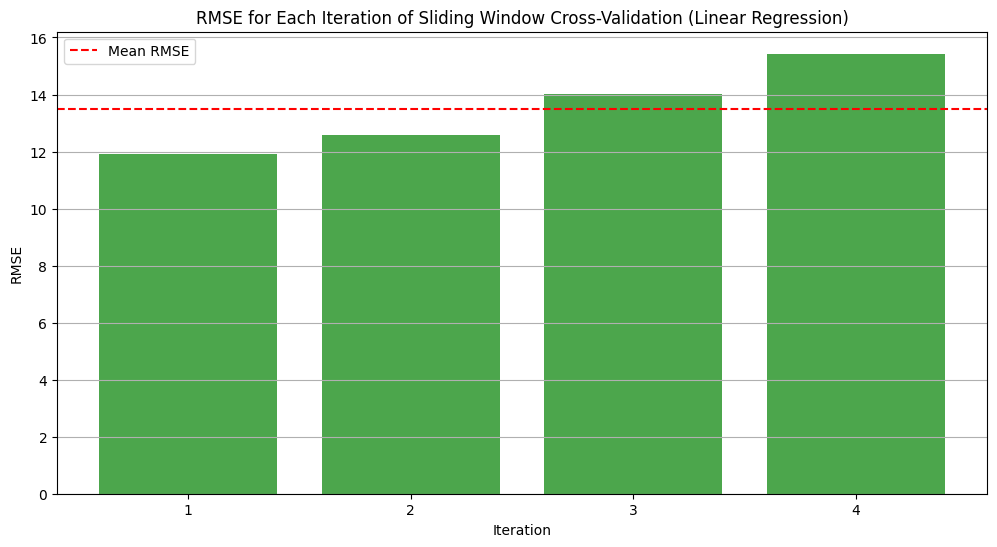

In [ ]:
iterations = list(range(1, split))
plt.figure(figsize=(12, 6))
plt.bar(iterations, lin_reg_rmse, color='green', alpha=0.7)
plt.axhline(np.mean(lin_reg_rmse), color='red', linestyle='--', label="Mean RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE for Each Iteration of Sliding Window Cross-Validation (Linear Regression)")
plt.xticks(iterations)
plt.legend()  # To display the legend for the mean line
plt.grid(axis='y')

Importance of features:
Reference category 
 event_type = None 
 weekday = Friday 
 store_id = store_id_CA_1 
 dept_id = dept_id_FOODS_1 



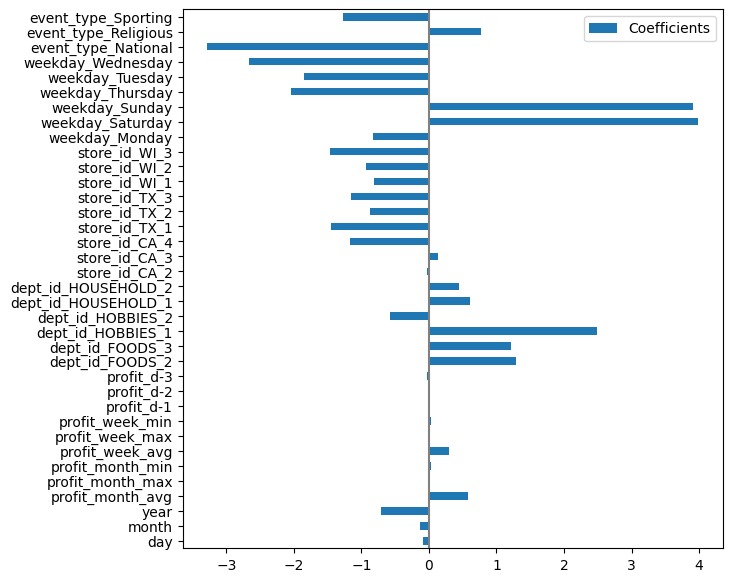

In [ ]:
print("Importance of features:")
print("Reference category \n event_type = None \n weekday = Friday \n store_id = store_id_CA_1 \n dept_id = dept_id_FOODS_1 \n")

coefs = pd.DataFrame(
    best_model_lin_reg.coef_, columns=["Coefficients"], index=X_train.columns
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
#Random Forest model
split = 5
size  = math.floor(df_validation.d.max()/split)
last_add = df_validation.d.max()%split
SEED = 88
forest_model_cv = RandomForestRegressor(random_state=SEED)
rndm_forest_rmse = []
rndm_forest_best_params = []
rndm_forest_best_estimatiors = []
hyper_grid = {'n_estimators': [50,80,100,120],
               'min_samples_split': [50,80,100,120]}
grid_search =  GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# i=1
# i+=1
for i in range(1,split):
    extra = 0
    if i == split-1:
        extra = last_add
    X_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].drop(columns=["profit","d"])
    X_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].drop(columns=["profit","d"])
    y_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].profit
    y_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].profit
    grid_search.fit(X_train, y_train.values.ravel())
    rndm_forest_best_params.append(grid_search.best_params_)
    forest_model_opt = grid_search.best_estimator_
    y_pred = forest_model_opt.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    rndm_forest_best_estimatiors.append(forest_model_opt)
    rndm_forest_rmse.append(np.sqrt(mse))

print(f"Mean RMSE of Random Forest model is {np.mean(rndm_forest_rmse)}")
best_rndm_forest_model = rndm_forest_best_estimatiors[np.argmin(rndm_forest_rmse)]

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mean RMSE of Random Forest model is 13.492747498207018


In [ ]:
with open('../models/rndm_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rndm_forest_model, file)

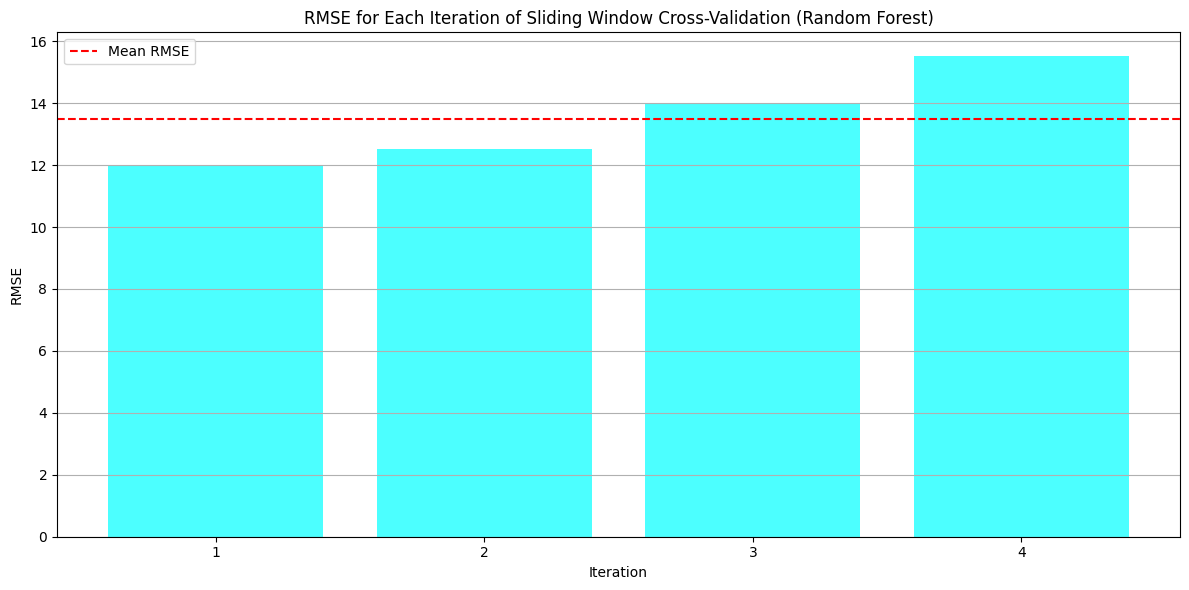

Best hyperparameters for iteration 1: {'min_samples_split': 120, 'n_estimators': 100}
Best hyperparameters for iteration 2: {'min_samples_split': 80, 'n_estimators': 120}
Best hyperparameters for iteration 3: {'min_samples_split': 80, 'n_estimators': 80}
Best hyperparameters for iteration 4: {'min_samples_split': 120, 'n_estimators': 100}


In [ ]:
#Bar chart for RMSE for each iteration
iterations = list(range(1, split))
plt.figure(figsize=(12, 6))
plt.bar(iterations, rndm_forest_rmse, color='cyan', alpha=0.7)
mean_rmse = np.mean(rndm_forest_rmse)

plt.axhline(mean_rmse, color='red', linestyle='--', label="Mean RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE for Each Iteration of Sliding Window Cross-Validation (Random Forest)")
plt.xticks(iterations)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

for i, params in enumerate(rndm_forest_best_params, 1):
    print(f"Best hyperparameters for iteration {i}: {params}")

In [ ]:
# Training loop for a single feature: profit_d-1
for i in range(1,split):
    extra = 0
    if i == split:
        extra = last_add
    X_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)]["profit_d-1"].values.reshape(-1, 1)
    X_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)]["profit_d-1"].values.reshape(-1, 1)
    y_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].profit
    y_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].profit
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    lin_reg_models.append(model)
    lin_reg_rmse.append(np.sqrt(mse))


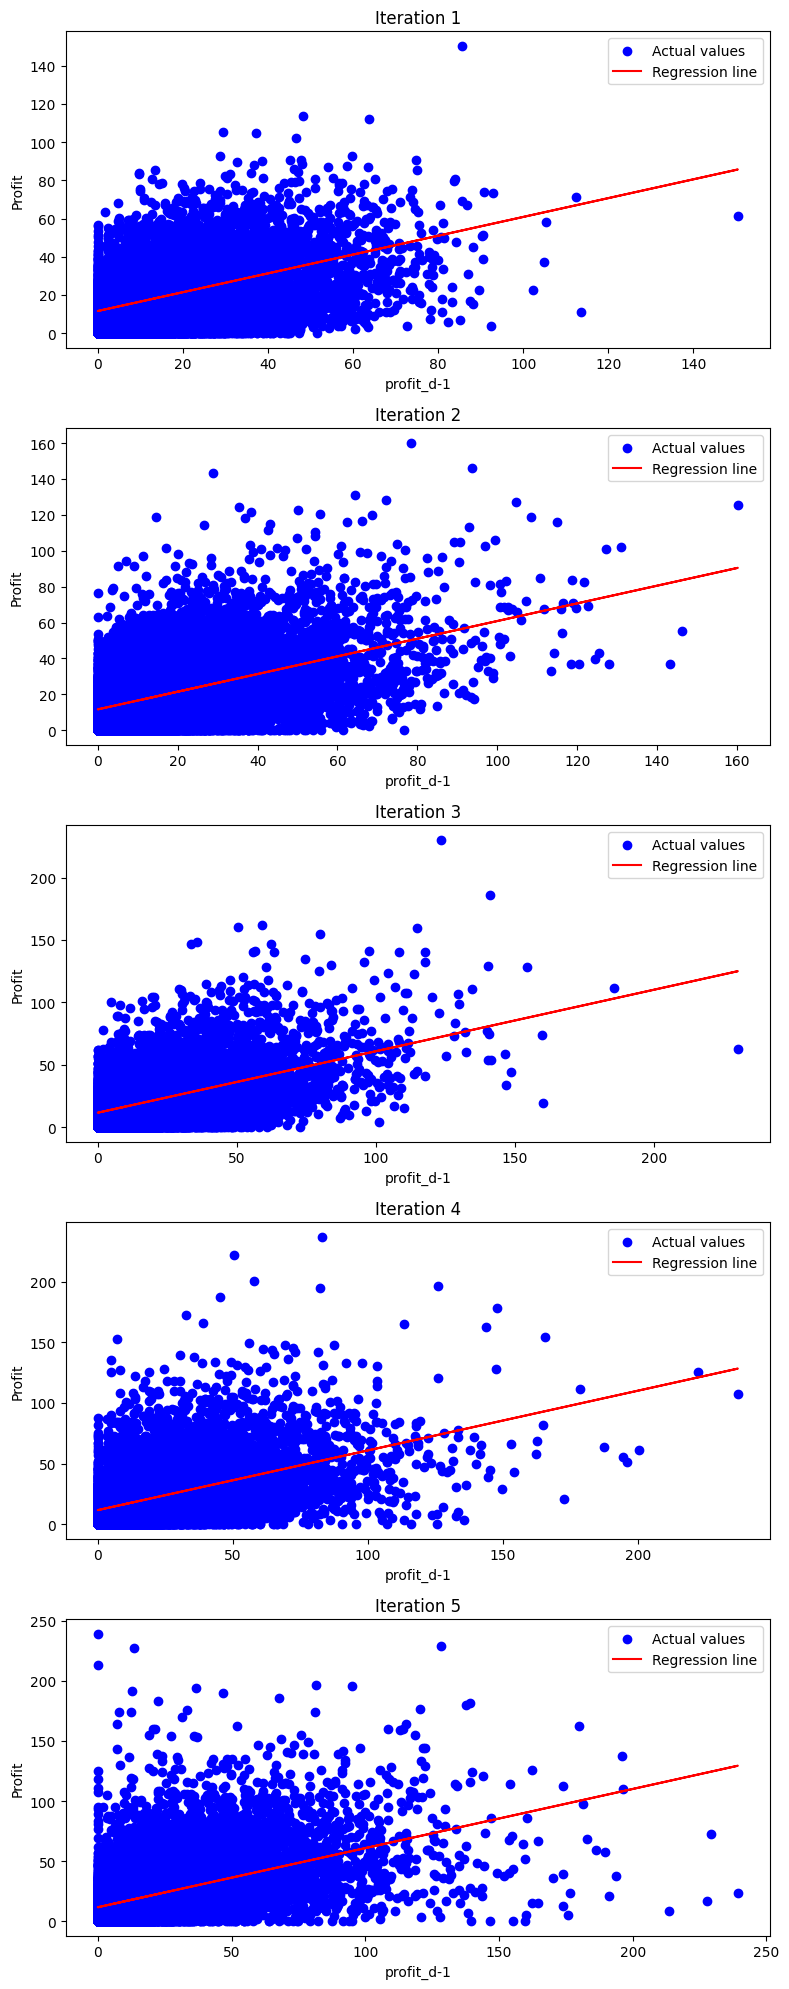

In [ ]:
fig, axes = plt.subplots(nrows=split, figsize=(8, 4*split))

for i in range(split):
    extra = 0
    if i == split - 1:
        extra = last_add
    X_val = df_validation[(df_validation.d > i*size) & (df_validation.d <= (i+1)*size + extra)]["profit_d-1"]
    y_val = df_validation[(df_validation.d > i*size) & (df_validation.d <= (i+1)*size + extra)].profit

    # Scatter plot
    axes[i].scatter(X_val, y_val, color='blue', label='Actual values')

    # Regression line
    y_pred = lin_reg_models[i].predict(X_val.values.reshape(-1, 1))
    axes[i].plot(X_val, y_pred, color='red', label='Regression line')
    axes[i].set_title(f"Iteration {i+1}")
    axes[i].set_xlabel('profit_d-1')
    axes[i].set_ylabel('Profit')
    axes[i].legend()

plt.tight_layout()
plt.show()

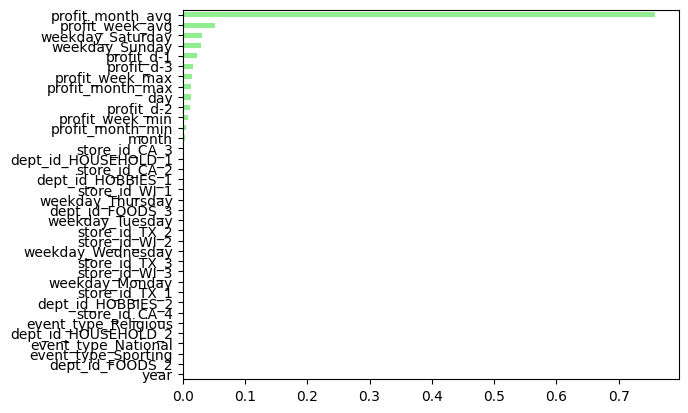

In [ ]:
importances_rf = pd.Series(best_rndm_forest_model.feature_importances_, index = df_validation.drop(columns=["profit","d"]).columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

In [ ]:
#XGBoost model
split = 5
size  = math.floor(df_validation.d.max()/split)
last_add = df_validation.d.max()%split
SEED = 88
model = xgb.XGBRegressor(seed=SEED, objective='reg:squarederror')
param_grid = {'learning_rate': [0.05,0.1,0.5], #alias eta, Step size shrinkage used in update to prevents overfitting.
    'n_estimators': [50,80,100,120],
    'subsample': [0.5, 1], #Subsample ratio of the training instances
    'max_depth': [1, 3, 5, 10],
    }

grid_mse = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=3,
                        verbose=1,
                        n_jobs=-1)
xgb_rmse = []
xgb_params = []
xgb_estimatiors = []

# i=1
# i+=1
for i in range(1,split):
    extra = 0
    if i == split-1:
        extra = last_add
    X_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].drop(columns=["profit","d"])
    X_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].drop(columns=["profit","d"])
    y_train = df_validation[(df_validation.d>(i-1)*size)&(df_validation.d<=i*size)].profit
    y_validation = df_validation[(df_validation.d>i*size) & (df_validation.d <= (i+1)*size + extra)].profit
    grid_mse.fit(X_train, y_train)
    gbm_ins = grid_mse.best_estimator_
    xgb_params.append(grid_mse.best_params_)
    y_pred = gbm_ins.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    xgb_estimatiors.append(gbm_ins)
    xgb_rmse.append(np.sqrt(mse))

print(f"Mean RMSE of XGBoost model is {np.mean(xgb_rmse)}")
best_xgb_model = xgb_estimatiors[np.argmin(xgb_rmse)]

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Mean RMSE of XGBoost model is 13.355162364365338


In [ ]:
with open('../models/xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

In [ ]:
print(f"Mean RMSE of baseline model is {np.mean(rmse_baseline)}")
print(f"Mean RMSE of Linear Regression model is {np.mean(lin_reg_rmse)}")
print(f"Mean RMSE of Random Forest model is {np.mean(rndm_forest_rmse)}")
print(f"Mean RMSE of XGBoost model is {np.mean(xgb_rmse)}")

Mean RMSE of baseline model is 18.240011632565412
Mean RMSE of Linear Regression model is 13.485027660297172
Mean RMSE of Random Forest model is 13.492747498207018
Mean RMSE of XGBoost model is 13.355162364365338


Models have almost same RMSE. Even though that XGBoost has lowest RMSE. It is not much lower than RMSE of Linear Regression which is quite easier to perform and to interpret. So that is reason why we decided to use **Linear Regression** as a model for predicting.

In [ ]:
#Final RMSE test
model = best_model_lin_reg

X_test = df_test.drop(columns=["profit","d"])
y_test = df_test.profit
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE on test data for Linear Regression model is {np.sqrt(mse)}")

RMSE on test data for Linear Regression model is 17.70311140936572
